# Notebook for results included in the paper *Contextual Importance and Utility in Python: New Functionality and Insights with the py-ciu Package* for XAI workshop at IJCAI-2024


Alternative name: 
Potential Influence Plot (PIP)?
Feature Influence Potential (FIP) plot?

Necessary imports: 

In [53]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.ensemble import RandomForestClassifier
import ciu
from lime.lime_tabular import LimeTabularExplainer
import shap

Some notebook-level specifications:

In [54]:
plot_save_path = '/Users/framling/Documents/Publications/XAI_WS_IJCAI_2024/Figures/'

## Some useful functions

In [55]:
def get_minmax_out(f, inp):
    outvals = f(inp)
    outmin = np.min(outvals)
    outmax = np.max(outvals)
    return outmin, outmax

def scaled_yvals(y, minmax=[0, 1]):
    return (y - minmax[0])/(minmax[1] - minmax[0])

class ScaledFunc:
    def __init__(self, f, minmax_out):
        self.f = f
        self.minmax_out = minmax_out

    def predict(self, inp):
        return scaled_yvals(self.f(inp), self.minmax_out)
   

Own influence plot function, for consistency:

In [56]:
def plot_influence(names, values, figsize=(6,3)):
    nfeatures = len(names)
    fig, ax = plt.subplots(figsize=figsize)
    y_pos = np.arange(nfeatures)
    plt.xlabel("ϕ")
    for m in range(len(values)):
        ax.barh(y_pos[m], values[m], color=["firebrick" if values[m] < 0 else "steelblue"],
            edgecolor="#808080", zorder=2)
    plt.ylabel("Features")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.set_facecolor(color="#D9D9D9")
    ax.grid(which = 'minor')
    ax.grid(which='minor', color='white')
    ax.grid(which='major', color='white')
    return fig


## Titanic data and model

Titanic, random forest:

In [57]:
data = pd.read_csv("https://raw.githubusercontent.com/KaryFramling/py-ciu/master/ciu_tests/data/titanic.csv")
data = data.drop(data.columns[0], axis=1)
unused = ['PassengerId','Cabin','Name','Ticket']

for col in unused:
    data = data.drop(col, axis=1)

np.random.seed(26)
from sklearn.preprocessing import LabelEncoder
titanic_data = data.dropna().apply(LabelEncoder().fit_transform)
titanic_train = titanic_data.drop('Survived', axis=1)

titanic_model = RandomForestClassifier(n_estimators=100)
titanic_model.fit(titanic_train, titanic_data.Survived)

# Create test instance (8-year old boy used in te book https://ema.drwhy.ai)
new_passenger = pd.DataFrame.from_dict({"Pclass" : [1], "Sex": [1], "Age": [8.0], "SibSp": [0], "Parch": [0], "Fare": [72.0], "Embarked": [2]})

# Category mapping is the right way to go
category_mapping = {
    'Sex': ['female','male'],
    'Pclass': ["1st","2nd","3rd"],#list(range(max(data.Pclass))),
    'SibSp': list(range(max(data.SibSp))),
    'Parch': list(range(max(data.Parch))),
    'Embarked': ["Belfast","Cherbourg","Queenstown","Southampton"]
}

titanic_surv_prob = titanic_model.predict_proba(new_passenger)[0,1]
print(titanic_surv_prob)

0.61


Get mean probability of survival, which we want to use for compatibility with SHAP values:

In [58]:
mean_surv_prob = np.mean(titanic_data['Survived'])
print(f'Mean survival probability for the whole data set is {mean_surv_prob}.')

Mean survival probability for the whole data set is 0.4044943820224719.


This data has quite few passengers. Here we just have a quick look at survived/not distribution depending on the class (1st, 2nd, 3rd):

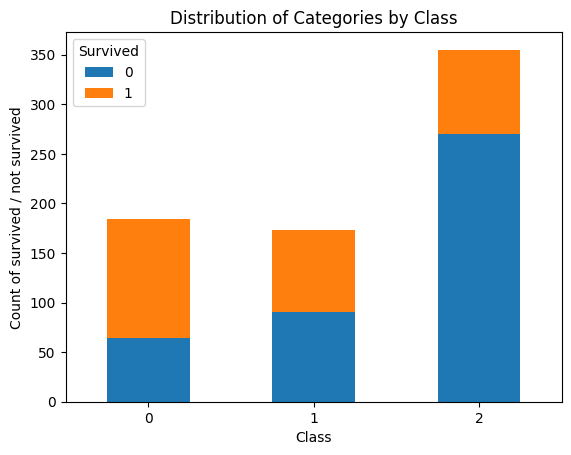

In [59]:
# Count the occurrences of each category in each class
count_data = titanic_data.groupby(['Pclass', 'Survived']).size().unstack()
# Create a bar plot
count_data.plot(kind='bar', stacked=True)
# Add labels and title
plt.title('Distribution of Categories by Class')
plt.xlabel('Class')
plt.ylabel('Count of survived / not survived')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Explanation models for Titanic

In [60]:
CIU_titanic = ciu.CIU(titanic_model.predict_proba, ['No', 'Yes'], data=titanic_train, category_mapping=category_mapping, neutralCU=mean_surv_prob)
SHAP_titanic_explainer = shap.Explainer(titanic_model, titanic_train)
#LIME_titanic_explainer = LimeTabularExplainer(titanic_train.values, feature_names=new_passenger.columns, discretize_continuous=False)
LIME_titanic_explainer = LimeTabularExplainer(titanic_train.values, feature_names=titanic_train.columns, discretize_continuous=True)


## Raw CIU results as DataFrame

In [61]:
CIUres_titanic = CIU_titanic.explain(new_passenger, output_inds=1)
CIUres_titanic

CI        CU     Cinfl outname  outval   feature  ymin  \
Pclass    0.079167  0.126316 -0.022022     Yes    0.61    Pclass  0.60   
Sex       0.268000  0.000000 -0.108404     Yes    0.61       Sex  0.61   
Age       0.643750  0.947573  0.349607     Yes    0.61       Age  0.00   
SibSp     0.160000  0.562500  0.025281     Yes    0.61     SibSp  0.52   
Parch     0.190000  0.000000 -0.076854     Yes    0.61     Parch  0.61   
Fare      0.180000  0.722222  0.057191     Yes    0.61      Fare  0.48   
Embarked  0.030000  0.333333 -0.002135     Yes    0.61  Embarked  0.60   

              ymax inputs  invals  neutralCU target_concept target_inputs  
Pclass    0.679167    [0]   [1.0]   0.404494           None          None  
Sex       0.878000    [1]   [1.0]   0.404494           None          None  
Age       0.643750    [2]   [8.0]   0.404494           None          None  
SibSp     0.680000    [3]   [0.0]   0.404494           None          None  
Parch     0.800000    [4]   [0.0]   0.404494           None          None  
Fare      0.660000    [5]  [72.0]   0.404494           None          None  
Embarked  0.630000    [6]   [2.0]   0.404494           None          None

## Input-output plots

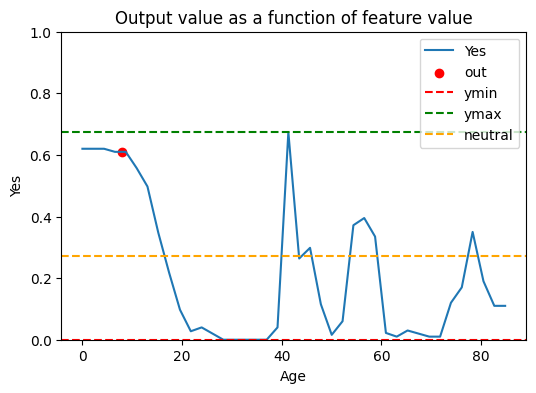

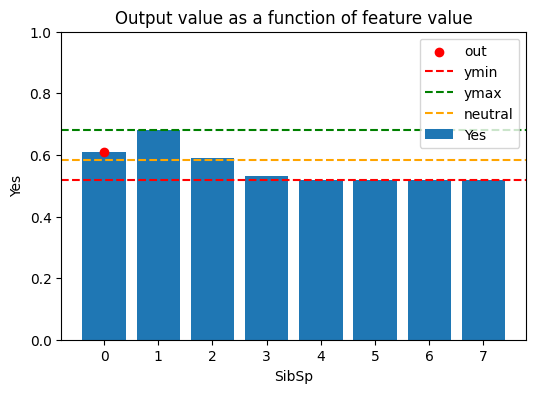

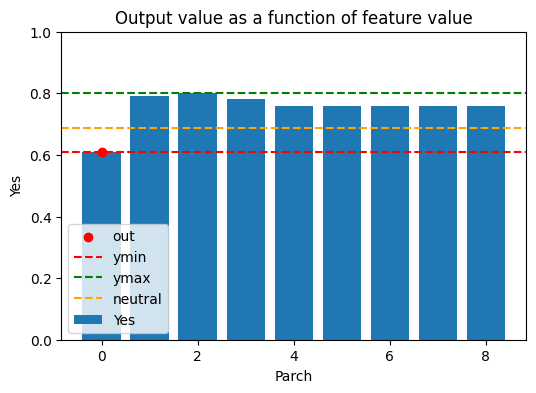

In [62]:
CIUres_titanic = CIU_titanic.explain(new_passenger, output_inds=1)
#CIU_titanic.plot_influence(CIUres, figsize=(6,3))
CIU_titanic.plot_input_output(ind_input=2, output_inds=1, illustrate_CIU=True)
plt.savefig(plot_save_path+'Titanic_IO_Age.pdf', format='pdf')
CIU_titanic.plot_input_output(ind_input=3, output_inds=1, illustrate_CIU=True)
plt.savefig(plot_save_path+'Titanic_IO_Sibsp.pdf', format='pdf')
CIU_titanic.plot_input_output(ind_input=4, output_inds=1, illustrate_CIU=True)
plt.savefig(plot_save_path+'Titanic_IO_Parch.pdf', format='pdf')

This is suprising: The probability of survival of the 8-year old boy would be even greater in 3rd class!

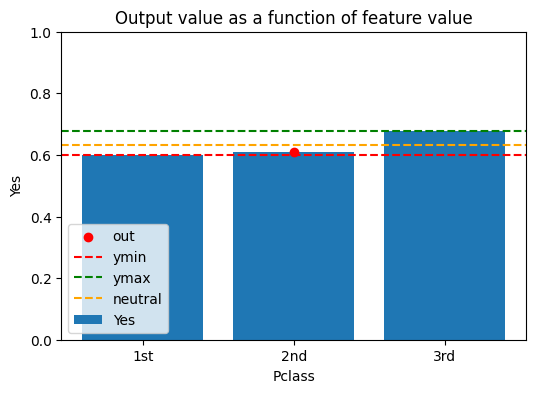

In [63]:
fig = CIU_titanic.plot_input_output(ind_input=0, output_inds=1, illustrate_CIU=True)

3D plot(s)

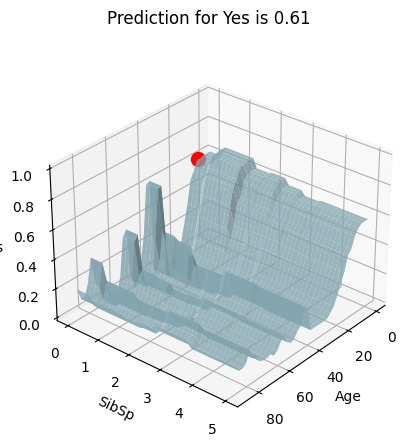

In [64]:
CIU_titanic.plot_3D([2,3], ind_output=1, azim=40) # Age versus number of siblings
plt.savefig(plot_save_path+'Titanic_3D_AgeSibsp.pdf', format='pdf')

## Influence plots

### Contextual influence

CIU's own plot:

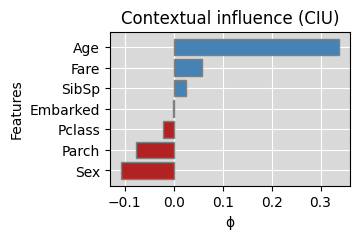

In [65]:
CIU_titanic.plot_influence(main="Contextual influence (CIU)", figsize=(4,2))
plt.subplots_adjust(left=0.3)
plt.savefig(plot_save_path+'Titanic_Cinfl.pdf', format='pdf')

Unified plot:

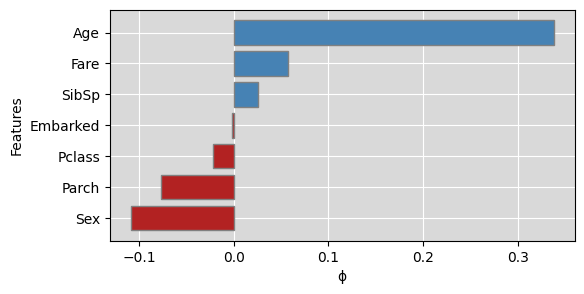

In [66]:
sorted_ciu = sorted(zip(CIUres_titanic.loc[:,'Cinfl'], titanic_train.columns))
v, n = zip(*sorted_ciu)
fig = plot_influence(n, v)
#plt.savefig(plot_save_path+'TitanicCinfl.pdf', format='pdf')

### SHAP

Sort according to influence:

In [67]:
shap_values = SHAP_titanic_explainer(new_passenger)
sorted_shap = sorted(zip(shap_values.values[0,:,1], titanic_train.columns))
v, n = zip(*sorted_shap)

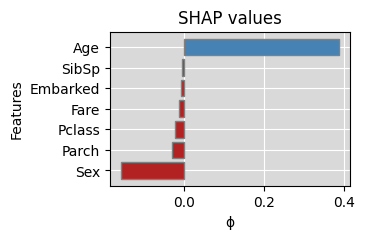

In [68]:
f = plot_influence(n, v, figsize=(4,2))
f.axes[0].set_title("SHAP values")
plt.subplots_adjust(left=0.3)
plt.savefig(plot_save_path+'TitanicSHAP.pdf', format='pdf')

SHAP's own plot:

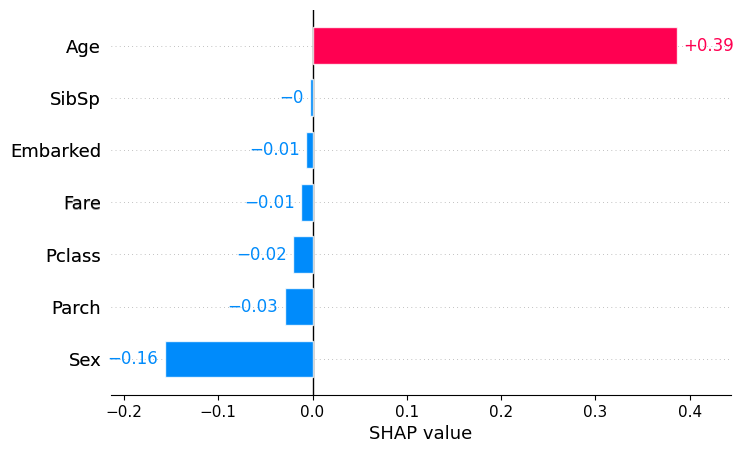

In [69]:
shap.plots.bar(shap_values[0,:,1], order=np.argsort(shap_values[0,:,1].values)[::-1])

### LIME

Some challenges with LIME here. We have to use 'discretize_continuous=True' for getting reasonable results but then it becomes challenging to extract features and sort them properly. 

In [70]:
def lime_imps_orig_order(lime_expl, orig_names):
    imps = dict(lime_expl.as_list())
    imps_original_order = {}
    for fname in orig_names:
        imps_original_order[fname] = imps[fname]
    return(list(imps_original_order.values()))

In [71]:
num_features = titanic_train.shape[1]
explanation = LIME_titanic_explainer.explain_instance(new_passenger.iloc[0], titanic_model.predict_proba, num_features=num_features)
#lime_imps = lime_imps_orig_order(explanation, new_passenger.columns)

/Users/framling/anaconda3/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/framling/anaconda3/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/Users/framling/anaconda3/lib/python3.11/site-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/framling/anaconda3/lib/python3.11/site-packages

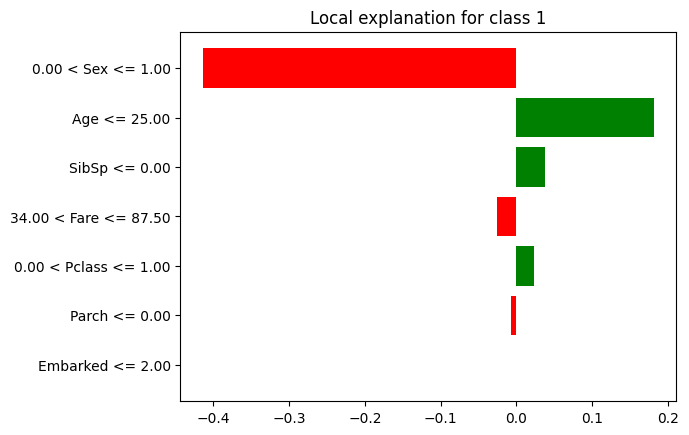

In [72]:
# LIME's own functions
#explanation.show_in_notebook()
p = explanation.as_pyplot_figure(label=1)

In [73]:
# sorted_lime = sorted(zip(lime_imps, titanic_train.columns))
# v, n = zip(*sorted_lime)
# plot_influence(n, v)

Something strange with LIME results here, test other code:

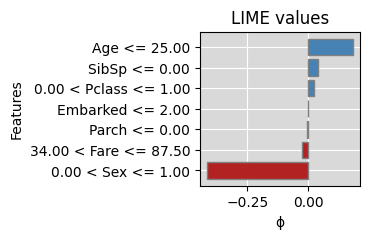

In [74]:
# Our own plot
l = explanation.as_list()
df = pd.DataFrame(l)
feature_names = df.iloc[:,0]
infl = df.iloc[:,1]
nfeatures = len(feature_names)
fig, ax = plt.subplots(figsize=(4,2))
y_pos = np.arange(nfeatures)
infl, feature_names = (list(t) for t in zip(*sorted(zip(infl, feature_names))))
plt.title("LIME values")
plt.xlabel("ϕ")
for m in range(len(infl)):
    ax.barh(y_pos[m], infl[m], color=["firebrick" if infl[m] < 0 else "steelblue"],
            edgecolor="#808080", zorder=2)
plt.ylabel("Features")
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.set_facecolor(color="#D9D9D9")
ax.grid(which = 'minor')
ax.grid(which='minor', color='white')
ax.grid(which='major', color='white')
plt.subplots_adjust(left=0.5)
plt.savefig(plot_save_path+'TitanicLIME.pdf', format='pdf')
plt.show()

## CIU

With old colour coding:

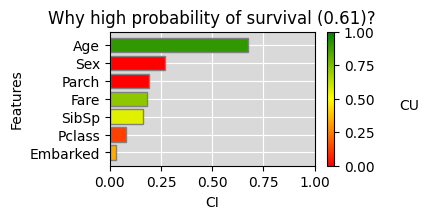

In [75]:
CIU_titanic.plot_ciu(main=f"Why high probability of survival ({titanic_surv_prob})?", figsize=(4,2))
plt.subplots_adjust(left=0.21, right=0.85, bottom=0.21)
plt.savefig(plot_save_path+'TitanicCIU.pdf', format='pdf')

Potential Influence / Quid-SI plot:

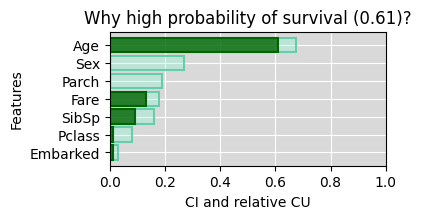

In [76]:
CIU_titanic.plot_ciu(plot_mode='overlap', main=f"Why high probability of survival ({titanic_surv_prob})?", figsize=(4,2))
plt.subplots_adjust(left=0.21, right=None, bottom=0.21)
plt.savefig(plot_save_path+'TitanicCIU_overlap.pdf', format='pdf')

Textual explanation, with text effects:

In [77]:
from IPython.display import Markdown
markdown_text = CIU_titanic.textual_explanation(use_markdown_effects=True)
Markdown(markdown_text)

The explained value is ***Yes*** with the value 0.61 (CU=0.61), which is **higher than average utility**.<br>Feature *Pclass* has **very low importance (CI=0.08)** and has value(s) 1.0, which is **low utility (CU=0.13)**<br>Feature *Sex* has **low importance (CI=0.27)** and has value(s) 1.0, which is **low utility (CU=0.00)**<br>Feature *Age* has **high importance (CI=0.67)** and has value(s) 8.0, which is **high utility (CU=0.91)**<br>Feature *SibSp* has **very low importance (CI=0.16)** and has value(s) 0.0, which is **higher than average utility (CU=0.56)**<br>Feature *Parch* has **very low importance (CI=0.19)** and has value(s) 0.0, which is **low utility (CU=0.00)**<br>Feature *Fare* has **very low importance (CI=0.18)** and has value(s) 72.0, which is **higher than average utility (CU=0.72)**<br>Feature *Embarked* has **very low importance (CI=0.03)** and has value(s) 2.0, which is **lower than average utility (CU=0.33)**<br>

### Beeswarm plots

In [78]:
#!pip install kaleido # For the moment only got to work with Python 3.11.5 (not 3.12)

In [79]:
import kaleido

In [80]:
#!pip install -U kaleido
from sklearn.model_selection import train_test_split
import xgboost as xgb
from ciu import ciuplots

California housing as alternative to Boston

In [81]:
def california(n_points=None):
    """Return the California housing data in a structured format.

    Parameters
    ----------
    n_points : int, optional
        Number of data points to sample. If provided, randomly samples the specified number of points.

    Returns
    -------
    Tuple of pandas DataFrame containing the data and a numpy array representing the target.
        The data include the following features:

        * ``MedInc`` : Median income in block
        * ``HouseAge`` : Median house age in block
        * ``AveRooms`` : Average rooms in dwelling
        * ``AveBedrms`` : Average bedrooms in dwelling
        * ``Population`` : Block population
        * ``AveOccup`` : Average house occupancy
        * ``Latitude`` : House block latitude
        * ``Longitude`` : House block longitude

        The target column represents the median house value for California districts.

    References
    ----------
    California housing dataset: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

    Examples
    --------
    To get the processed data and target labels::

        data, target = shap.datasets.california()
    """
    d = sklearn.datasets.fetch_california_housing()
    df = pd.DataFrame(data=d.data, columns=d.feature_names)
    target = d.target

    if n_points is not None:
        df = shap.utils.sample(df, n_points, random_state=0)
        target = shap.utils.sample(target, n_points, random_state=0)

    return df, target


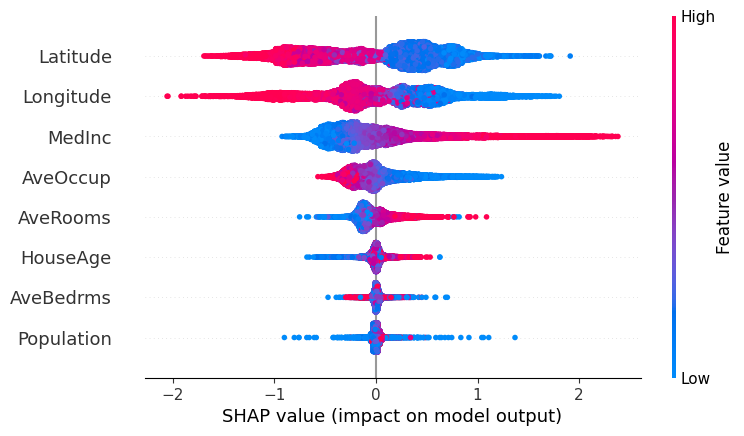

In [82]:
import shap
import xgboost

# train an XGBoost model
X, y = shap.datasets.california()
california_model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(california_model)
shap_values = explainer(X)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)

In [83]:
out_minmaxs = pd.DataFrame({'mins': [min(y)], 'maxs': max(y)})
#california_model.predict(X)
mean_california_out = np.mean(y)
neutralCU = (mean_california_out - min(y))/(max(y) - min(y))
CIU = ciu.CIU(california_model.predict, ['Price'], data=X, out_minmaxs=out_minmaxs, neutralCU=neutralCU)

Get Boston Housing data and train Gradient Boosting model:

In [84]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
boston_target = raw_df.values[1::2, 2]

boston_data = pd.DataFrame(data)
boston_data.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
np.random.seed(26) # We want to always get the same train/test sets and model here.
X_train, X_test, y_train, y_test = train_test_split(boston_data, boston_target, test_size=0.3, random_state=123)
boston_xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
boston_xgb_model.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

Since this is a regression task, we need to get the minimal and maximal output values in order to map output values to utility values. 

In [85]:
out_minmaxs = pd.DataFrame({'mins': [min(y_train)], 'maxs': max(y_train)})

Since we want to have something quite similar to the SHAP beeswarm for Contextual influence, we use a compatible neutral CU value:

In [86]:
mean_boston_out = np.mean(y_train)
neutralCU = (mean_boston_out - min(y_train))/(max(y_train) - min(y_train))
CIU = ciu.CIU(boston_xgb_model.predict, ['Price'], data=X_train, out_minmaxs=out_minmaxs, neutralCU=neutralCU)

In [87]:
CIUres = CIU.explain_all(X_test, do_norm_invals=True)
display(CIUres)

CI        CU     Cinfl outname     outval  feature       ymin  \
0     0.017942  0.000000 -0.007082   Price  19.113840     CRIM  19.113840   
1     0.027332  0.000000 -0.010788   Price  19.113840       ZN  19.113840   
2     0.053155  0.000000 -0.020981   Price  19.113840    INDUS  19.113840   
3     0.002327  0.000000 -0.000918   Price  19.113840     CHAS  19.113840   
4     0.048834  0.342554 -0.002547   Price  19.113840      NOX  18.361063   
...        ...       ...       ...     ...        ...      ...        ...   
1971  0.000000  0.000000 -0.000000   Price  21.273912      RAD  21.273912   
1972  0.025795  0.167980 -0.005848   Price  21.273912      TAX  21.078928   
1973  0.045318  0.000000 -0.017888   Price  21.273912  PTRATIO  21.273912   
1974  0.037479  0.505925  0.004168   Price  21.273912        B  20.420645   
1975  0.135616  0.286372 -0.014692   Price  21.273912    LSTAT  19.526260   

           ymax inputs     invals  neutralCU target_concept target_inputs  \
0     19.921244    [0]  [51.1358]   0.394708           None          None   
1     20.343763    [1]      [0.0]   0.394708           None          None   
2     21.505812    [2]     [18.1]   0.394708           None          None   
3     19.218536    [3]      [0.0]   0.394708           None          None   
4     20.558607    [4]    [0.597]   0.394708           None          None   
...         ...    ...        ...        ...            ...           ...   
1971  21.273912    [8]     [24.0]   0.394708           None          None   
1972  22.239691    [9]    [666.0]   0.394708           None          None   
1973  23.313242   [10]     [20.2]   0.394708           None          None   
1974  22.107193   [11]   [393.37]   0.394708           None          None   
1975  25.629000   [12]    [14.36]   0.394708           None          None   

     instance_name norm_invals  
0              410    0.574651  
1              410         0.0  
2              410    0.646628  
3              410         0.0  
4              410    0.427975  
...            ...         ...  
1971           472         1.0  
1972           472    0.914122  
1973           472    0.808511  
1974           472    0.991099  
1975           472    0.358298  

[1976 rows x 15 columns]

In [88]:
fig = ciuplots.ciu_beeswarm(CIUres, legend_title='Value')
fig.update_layout(height=300, width=400, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual Importance (CI)'))
fig.write_image(plot_save_path+"CaliforniaBeeswarm_CI.pdf")
fig.show()

In [89]:
fig = ciuplots.ciu_beeswarm(CIUres, xcol='Cinfl', legend_title='Value')
fig.update_layout(height=300, width=400, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual influence'))
fig.write_image(plot_save_path+"CaliforniaBeeswarm_Cinfl.pdf")
fig.show()

In [90]:
fig = ciuplots.ciu_beeswarm(CIUres, xcol='CU', legend_title='Value')
fig.update_layout(height=300, width=400, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual Utility (CU)'))
fig.write_image(plot_save_path+"CaliforniaBeeswarm_CU.pdf")
fig.show()

For beeswarm we need to get results for all the instances that we want to include.

In [91]:
CIUres = CIU.explain_all(X_test, do_norm_invals=True)
display(CIUres)

CI        CU     Cinfl outname     outval  feature       ymin  \
0     0.017942  0.000000 -0.007082   Price  19.113840     CRIM  19.113840   
1     0.027332  0.000000 -0.010788   Price  19.113840       ZN  19.113840   
2     0.053155  0.000000 -0.020981   Price  19.113840    INDUS  19.113840   
3     0.002327  0.000000 -0.000918   Price  19.113840     CHAS  19.113840   
4     0.048834  0.342554 -0.002547   Price  19.113840      NOX  18.361063   
...        ...       ...       ...     ...        ...      ...        ...   
1971  0.000000  0.000000 -0.000000   Price  21.273912      RAD  21.273912   
1972  0.025795  0.167980 -0.005848   Price  21.273912      TAX  21.078928   
1973  0.045318  0.000000 -0.017888   Price  21.273912  PTRATIO  21.273912   
1974  0.037423  0.506681  0.004190   Price  21.273912        B  20.420645   
1975  0.135616  0.286372 -0.014692   Price  21.273912    LSTAT  19.526260   

           ymax inputs     invals  neutralCU target_concept target_inputs  \
0     19.921244    [0]  [51.1358]   0.394708           None          None   
1     20.343763    [1]      [0.0]   0.394708           None          None   
2     21.505812    [2]     [18.1]   0.394708           None          None   
3     19.218536    [3]      [0.0]   0.394708           None          None   
4     20.558607    [4]    [0.597]   0.394708           None          None   
...         ...    ...        ...        ...            ...           ...   
1971  21.273912    [8]     [24.0]   0.394708           None          None   
1972  22.239691    [9]    [666.0]   0.394708           None          None   
1973  23.313242   [10]     [20.2]   0.394708           None          None   
1974  22.104679   [11]   [393.37]   0.394708           None          None   
1975  25.629000   [12]    [14.36]   0.394708           None          None   

     instance_name norm_invals  
0              410    0.574651  
1              410         0.0  
2              410    0.646628  
3              410         0.0  
4              410    0.427975  
...            ...         ...  
1971           472         1.0  
1972           472    0.914122  
1973           472    0.808511  
1974           472    0.991099  
1975           472    0.358298  

[1976 rows x 15 columns]

In [92]:
fig = ciuplots.ciu_beeswarm(CIUres, legend_title='Value')
fig.update_layout(height=300, width=400, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual Importance (CI)'))
fig.write_image(plot_save_path+"CaliforniaBeeswarm_CI.pdf")
fig.show()

Then we can plot the beeswarm. We start by the default parameters, which plots CI values. 

In [93]:
import pkg_resources

def check_package(package_name):
    try:
        # Try to get the distribution information for the package
        distribution = pkg_resources.get_distribution(package_name)
        version = distribution.version
        print(f"{package_name} is installed (version: {version})")
    except pkg_resources.DistributionNotFound:
        print(f"{package_name} is not installed")

# Example usage
check_package("kaleido")

kaleido is installed (version: 0.2.1)


In [94]:
fig = ciuplots.ciu_beeswarm(CIUres, legend_title='Value')
fig.update_layout(height=300, width=400, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual Importance (CI)'))
# fig.update_layout(
#     title='CI versus input value for all features',
#     xaxis=dict(title='Contextual Importance (CI)'),
#     yaxis=dict(title='Feature'),
# )
fig.write_image(plot_save_path+"BostonBeeswarm_CI.pdf")
fig.show()

We can also plot Contextual influence values, which will give us something that looks quite similar to the SHAP beeswarm, or to the R-CIU beeswarm.

In [95]:
fig = ciuplots.ciu_beeswarm(CIUres, xcol='Cinfl', legend_title='Value')
fig.update_layout(height=300, width=400, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual influence'))
fig.write_image(plot_save_path+'BostonBeeswarm_Cinfl.pdf', format='pdf')
fig.show()

Still with CU:

In [96]:
fig = ciuplots.ciu_beeswarm(CIUres, xcol='CU', legend_title='Value')
fig.update_layout(height=300, width=400, margin=dict(l=20, r=20, t=20, b=20), xaxis=dict(title='Contextual Utility (CU)'))
fig.write_image(plot_save_path+'BostonBeeswarm_CU.pdf', format='pdf')
fig.show()

## Intermediate Concepts

We use Ames Housing here.

In [97]:
df = pd.read_csv('https://raw.githubusercontent.com/KaryFramling/py-ciu/master/ciu_tests/data/AmesHousing.csv')

#Checking for missing data
missing_data_count = df.isnull().sum()
missing_data_percent = df.isnull().sum() / len(df) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})

missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

#This one has spaces for some reason
df.columns = df.columns.str.replace(' ', '')


#Taking care of missing values
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
df[group_1] = df[group_1].fillna("None")

# Group 2:
group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

df[group_2] = df[group_2].fillna(0)

# Group 3:
group_3a = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
df[group_3a] = pd.DataFrame(imputer.fit_transform(df[group_3a]), index=df.index)

df.LotFrontage = df.LotFrontage.fillna(df.LotFrontage.mean())
df.GarageYrBlt = df.GarageYrBlt.fillna(df.YearBuilt)

#Label encoding
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)

data = df.drop(columns=['SalePrice'])
data = data.astype(float) # This is a "quick fix" to make everything into float. Some of these would rather need a category mapping. 
target = df.SalePrice

In [98]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)
np.random.seed(26) # We want to always get the same Random Forest model here.
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 15, alpha = 10)
model.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

Basic CIU and explanation.

In [99]:
out_minmaxs = pd.DataFrame({'mins': [float(min(y_train))], 'maxs': [float(max(y_train))]})
print(f"The minimal price in the training set is ${min(y_train):.0f} and the maximal price is ${max(y_train):.0f}")

The minimal price in the training set is $0 and the maximal price is $1031


Get instance to explain and set up CIU explainer. We don't care about defining category mapping for the moment...

In [100]:
ames_instance = X_test.iloc[[345]]
CIU_ames = ciu.CIU(model.predict, ['Price'], data=X_train, out_minmaxs=out_minmaxs) #, category_mapping=category_mapping)
CIUres = CIU_ames.explain(ames_instance)
display(CIUres)

CI        CU     Cinfl outname      outval  \
Order          0.031089  0.975402  0.014780   Price  740.222046   
PID            0.030742  0.807310  0.009447   Price  740.222046   
MSSubClass     0.000000  0.000000 -0.000000   Price  740.222046   
MSZoning       0.003970  1.000000  0.001985   Price  740.222046   
LotFrontage    0.035820  0.737216  0.008497   Price  740.222046   
...                 ...       ...       ...     ...         ...   
MiscVal        0.000339  1.000000  0.000169   Price  740.222046   
MoSold         0.022351  0.537845  0.000846   Price  740.222046   
YrSold         0.010858  1.000000  0.005429   Price  740.222046   
SaleType       0.042302  1.000000  0.021151   Price  740.222046   
SaleCondition  0.006309  1.000000  0.003155   Price  740.222046   

                     feature        ymin        ymax inputs    invals  \
Order                  Order  708.957336  741.010498    [0]  [1561.0]   
PID                      PID  714.634338  746.329346    [1]  [2700.0]   
MSSubClass        MSSubClass  740.222046  740.222046    [2]    [11.0]   
MSZoning            MSZoning  736.128540  740.222046    [3]     [6.0]   
LotFrontage      LotFrontage  712.996338  749.926758    [4]    [20.0]   
...                      ...         ...         ...    ...       ...   
MiscVal              MiscVal  739.872620  740.222046   [76]     [0.0]   
MoSold                MoSold  727.828247  750.871704   [77]     [6.0]   
YrSold                YrSold  729.027527  740.222046   [78]     [2.0]   
SaleType            SaleType  696.609192  740.222046   [79]     [9.0]   
SaleCondition  SaleCondition  733.717407  740.222046   [80]     [4.0]   

               neutralCU target_concept target_inputs  
Order                0.5           None          None  
PID                  0.5           None          None  
MSSubClass           0.5           None          None  
MSZoning             0.5           None          None  
LotFrontage          0.5           None          None  
...                  ...            ...           ...  
MiscVal              0.5           None          None  
MoSold               0.5           None          None  
YrSold               0.5           None          None  
SaleType             0.5           None          None  
SaleCondition        0.5           None          None  

[81 rows x 13 columns]

Basic CIU plot.

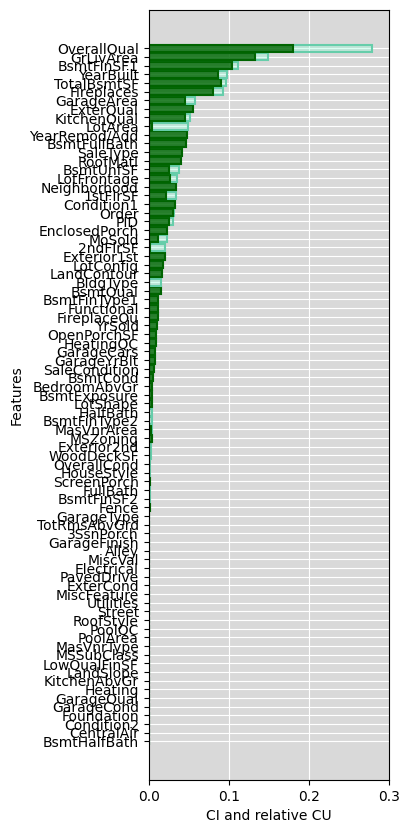

In [101]:
fig = CIU_ames.plot_ciu(CIUres, plot_mode='overlap', figsize=(4,10))
fig.axes[0].set_xlim(0,0.3)
plt.subplots_adjust(left=0.3)
plt.savefig(plot_save_path+'Ames_CIU_basic.pdf', format='pdf')

Specify a small vocabulary:

In [102]:
ames_voc = {
    "Garage":[c for c in df.columns if 'Garage' in c],
    "Basement":[c for c in df.columns if 'Bsmt' in c],
    "Lot":list(df.columns[[3,4,7,8,9,10,11]]),
    "Access":list(df.columns[[13,14]]),
    "House_type":list(df.columns[[1,15,16,21]]),
    "House_aesthetics":list(df.columns[[22,23,24,25,26]]),
    "House_condition":list(df.columns[[20,18,21,28,19,29]]),
    "First_floor_surface":list(df.columns[[43]]),
    "Above_ground_living area":[c for c in df.columns if 'GrLivArea' in c]
}
CIU_ames.vocabulary = ames_voc

Get top-level explanation by calling `explain_voc()`:

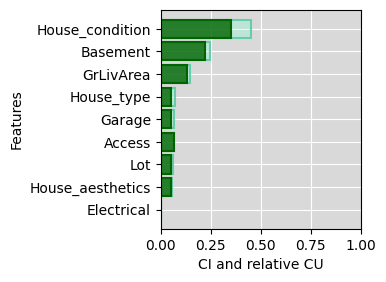

In [103]:
top_res = CIU_ames.explain_voc(ames_instance, nsamples=10000)
CIU_ames.plot_ciu(top_res, plot_mode='overlap', figsize=(4,3))
plt.subplots_adjust(left=0.4, bottom=0.15)
plt.savefig(plot_save_path+'Ames_CIU_top_level.pdf', format='pdf')

One way of explaining intermediate concepts is to just indicate the target concept (intermediate concept):

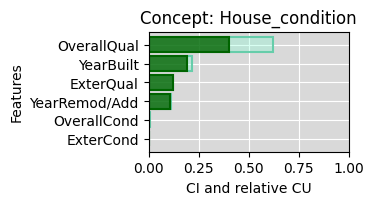

In [104]:
tconcept = "House_condition"
res = CIU_ames.explain(ames_instance, nsamples=1000, target_concept=tconcept, target_ciu=top_res)
CIU_ames.plot_ciu(res, plot_mode='overlap', figsize=(4,2), main=f"Concept: {tconcept}")
plt.subplots_adjust(left=0.4, bottom=0.25, top=0.85) # Not obvious how to adjust these...
plt.savefig(plot_save_path+'Ames_CIU_house_condition.pdf', format='pdf')

## Contrastive explanations

In [105]:
from ciu.CIU import contrastive_ciu

inst1 = ames_instance
inst2 = X_test.iloc[[302]]
CIUres1 = CIU_ames.explain_voc(inst1)
CIUres2 = CIU_ames.explain_voc(inst2)
display(CIUres1)
display(CIUres2)
contrastive = contrastive_ciu(CIUres1, CIUres2)
display(contrastive)

CI        CU     Cinfl outname      outval  \
Garage            0.046972  1.000000  0.023486   Price  740.222046   
Basement          0.217135  1.000000  0.108568   Price  740.222046   
Lot               0.049527  1.000000  0.024764   Price  740.222046   
Access            0.066235  0.998431  0.033013   Price  740.222046   
House_type        0.065835  0.756982  0.016918   Price  740.222046   
House_aesthetics  0.056205  0.938650  0.024654   Price  740.222046   
House_condition   0.433799  0.792288  0.126794   Price  740.222046   
Electrical        0.000295  1.000000  0.000147   Price  740.222046   
GrLivArea         0.148783  0.894027  0.058625   Price  740.222046   

                           feature        ymin        ymax  \
Garage                      Garage  691.794189  740.222046   
Basement                  Basement  516.355713  740.222046   
Lot                            Lot  689.159302  740.222046   
Access                      Access  672.041138  740.329163   
House_type              House_type  688.841125  756.717163   
House_aesthetics  House_aesthetics  685.829773  743.777100   
House_condition    House_condition  385.873962  833.120544   
Electrical              Electrical  739.918396  740.222046   
GrLivArea                GrLivArea  603.082153  756.477905   

                                                        inputs  \
Garage                            [59, 60, 61, 62, 63, 64, 65]   
Basement          [31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]   
Lot                                    [3, 4, 7, 8, 9, 10, 11]   
Access                                                [13, 14]   
House_type                                     [1, 15, 16, 21]   
House_aesthetics                          [22, 23, 24, 25, 26]   
House_condition                       [20, 18, 21, 28, 19, 29]   
Electrical                                                [43]   
GrLivArea                                                 [47]   

                                                             invals  \
Garage                      [1.0, 103.0, 0.0, 2.0, 224.0, 5.0, 5.0]   
Basement          [0.0, 5.0, 1.0, 2.0, 941.0, 6.0, 0.0, 81.0, 84...   
Lot                            [6.0, 20.0, 1.0, 0.0, 1.0, 0.0, 4.0]   
Access                                                   [6.0, 2.0]   
House_type                                 [2700.0, 2.0, 4.0, 55.0]   
House_aesthetics                          [3.0, 1.0, 5.0, 5.0, 4.0]   
House_condition                   [111.0, 6.0, 55.0, 2.0, 4.0, 4.0]   
Electrical                                                    [4.0]   
GrLivArea                                                   [711.0]   

                  neutralCU target_concept target_inputs  
Garage                  0.5           None          None  
Basement                0.5           None          None  
Lot                     0.5           None          None  
Access                  0.5           None          None  
House_type              0.5           None          None  
House_aesthetics        0.5           None          None  
House_condition         0.5           None          None  
Electrical              0.5           None          None  
GrLivArea               0.5           None          None

CI        CU     Cinfl outname      outval  \
Garage            0.090084  0.849025  0.031442   Price  568.000977   
Basement          0.163685  0.378271 -0.019925   Price  568.000977   
Lot               0.047238  1.000000  0.023619   Price  568.000977   
Access            0.005766  1.000000  0.002883   Price  568.000977   
House_type        0.088053  0.835702  0.029560   Price  568.000977   
House_aesthetics  0.043570  0.558171  0.002534   Price  568.000977   
House_condition   0.339107  0.872017  0.126154   Price  568.000977   
Electrical        0.000000  0.000000 -0.000000   Price  568.000977   
GrLivArea         0.140341  0.306607 -0.027141   Price  568.000977   

                           feature        ymin        ymax  \
Garage                      Garage  489.145996  582.023071   
Basement                  Basement  504.164093  672.923645   
Lot                            Lot  519.298279  568.000977   
Access                      Access  562.055908  568.000977   
House_type              House_type  492.133484  582.916443   
House_aesthetics  House_aesthetics  542.927551  587.848267   
House_condition    House_condition  263.126770  612.746521   
Electrical              Electrical  568.000977  568.000977   
GrLivArea                GrLivArea  523.637451  668.329346   

                                                        inputs  \
Garage                            [59, 60, 61, 62, 63, 64, 65]   
Basement          [31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49]   
Lot                                    [3, 4, 7, 8, 9, 10, 11]   
Access                                                [13, 14]   
House_type                                     [1, 15, 16, 21]   
House_aesthetics                          [22, 23, 24, 25, 26]   
House_condition                       [20, 18, 21, 28, 19, 29]   
Electrical                                                [43]   
GrLivArea                                                 [47]   

                                                             invals  \
Garage                      [1.0, 105.0, 2.0, 2.0, 208.0, 5.0, 5.0]   
Basement          [0.0, 2.0, 3.0, 6.0, 0.0, 6.0, 0.0, 980.0, 672...   
Lot                            [2.0, 23.0, 2.0, 3.0, 3.0, 0.0, 0.0]   
Access                                                  [24.0, 2.0]   
House_type                                  [916.0, 2.0, 4.0, 57.0]   
House_aesthetics                        [1.0, 1.0, 13.0, 14.0, 3.0]   
House_condition                   [113.0, 6.0, 57.0, 2.0, 4.0, 4.0]   
Electrical                                                    [4.0]   
GrLivArea                                                   [459.0]   

                  neutralCU target_concept target_inputs  
Garage                  0.5           None          None  
Basement                0.5           None          None  
Lot                     0.5           None          None  
Access                  0.5           None          None  
House_type              0.5           None          None  
House_aesthetics        0.5           None          None  
House_condition         0.5           None          None  
Electrical              0.5           None          None  
GrLivArea               0.5           None          None

Garage              0.007092
Basement            0.134999
Lot                 0.000000
Access             -0.000104
House_type         -0.005183
House_aesthetics    0.021385
House_condition    -0.034586
Electrical          0.000295
GrLivArea           0.087398
dtype: float64

Contrastive plot uses "influence look-and-feel" because we compare instance2 against instance 1:

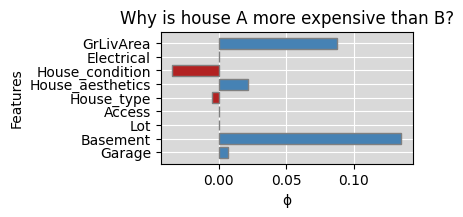

In [106]:
ciuplots.plot_contrastive(CIUres1, CIUres2, main="Why is house A more expensive than B?", figsize=(4.5,2))
plt.subplots_adjust(left=0.34, bottom=0.22)
plt.savefig(plot_save_path+'Ames_CIU_contrastive.pdf', format='pdf')